# PYTORCH TENSORBOARD SUPPORT

INtroduction

We will be training a varient of LeNet-5 against Fashion-MNIST dataset. It is a set of image tiles depicting various garments

In [1]:
#PyTorch Model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Image datasets adn image manipulations
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

#PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

Showing Images in Tensorbaord

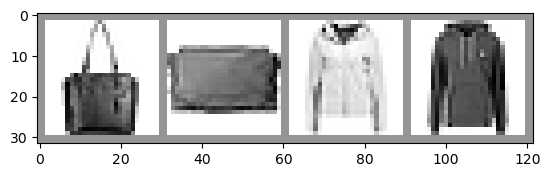

In [2]:
#Gather datsets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validation splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data', 
                                                download=True,
                                                train=True,
                                                transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data', 
                                                  download=True,
                                                  train=False,
                                                  transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=2)

validation_loader = torch.utils.data.DataLoader(validation_set,
                                               batch_size=4,
                                               shuffle=False,
                                               num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
 
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg= img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Extract a batch of 4 images
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Creating a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [3]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# Write image data to Tensorboard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

Graphing Scalars to Visualize Training

TensorBoard is useful in tracking the progress and efficiency of the training model. 




\n\n

Let's define a model to categorize image tiles, and an optimizer and loss function for training

In [5]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Now let's train a singe epoch, and evaluate the training vs. validation set losses every 1000 batches

In [7]:
print(len(validation_loader))
for epoch in range(1):
    running_loss = 0.0
    
    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 1000 == 999:   #Iteration every 1000 mini-batches
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            
            net.train(False)  # No need to track gradient for validation
            for l, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)
            
            avg_loss = runnin_loss / 1000
            avg_vloss = running_loss / len(validation_loader)
            
            #Log the running loss avergared per batch
            writer.add_scalars('Training vs. Validation Loss', 
                              { 'Training' : avg_loss, 'Validation' : avg_vloss},
                              epoch * len(training_loader) + i)
            
            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


Visualizing the Models

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = next(dataiter)

#add_graph() will trae the samplle input through your moodel, and render it as graph
writer.add_graph(net, images)
writer.flush()


Visuzalizing the Dataset with Embeddings

In [11]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))

writer.flush()
writer.close()